
# 小地域の収入推定

```Data```フォルダには、小地域の収入データ(```income_district.csv```)と国勢調査の小地域集計データが格納されています。

国勢調査の小地域集計データ（人口構成、労働力構成、住宅形態など）から、その地域の収入を推定することが考えられます。推定のための機械学習・深層学習モデルを構築しなさい。


- データを観察・理解する上で、データの構造を説明しながら、適切なデータ整形を行いなさい
- データ構造や分析結果に対して、少なくとも二つの図で可視化を行いなさい
- モデルの精度を評価し、できるだけ精度が高いモデルを得るよう、適切な特徴量エンジニアリングやモデル選定の考えもまとめなさい


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

全ての変数を用いると処理が大変になるため、代表として、family, labor に含まれる変数を用いることにする。
直感的な予想として、家族が多い地域ほど収入が高い（消費も多くなると考えられるため）、労働者の数が多いほど収入が高いだろう。

In [111]:
family = pd.read_csv('Data/h27_family_df.csv')
labor = pd.read_csv('Data/h27_labor_df.csv')
income = pd.read_csv('Data/income_district.csv')

In [143]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']

c:\Users\YuYaTano\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


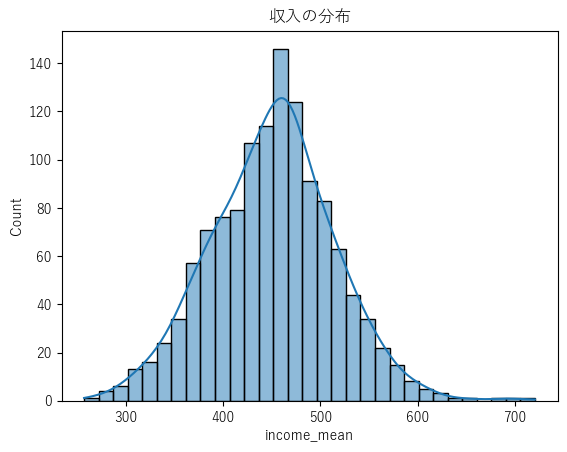

In [147]:
# 従属変数 income の分布を確認
sns.histplot(
	data = income,
	x='income_mean',
	kde=True,
	multiple='stack')
plt.title('収入の分布')
plt.show()
#図から、収入の分布は正規分布に近似していると考えられる。

以下分析の流れ
教師あり機械学習で回帰分析を行いたい。そのために、データを整形する。
データの特徴として、income_district.csvには、areaごとのデータが入っている。areaは、◯◯県◯◯市◯◯区のレベルである。
一方、国政調査のデータは更に細かく分かれている。
そこでまずは、それらのデータを area(district)ごとにまとめて、機械学習に用いるデータを作成する。

In [120]:
labor1= labor[labor["district2_id"].isna()]
labor2= labor1.drop(columns=["district2_id","level_identifier","state_name","city_name","district_name","district2_name"])
labor3 = labor2.replace('-', np.nan, inplace=False)
labor4 = labor3.astype(float)
labor4.head()

,district_id,labor_male,no_labor_male,labor_female,no_labor_female
0,23101.0,45761.0,15806.0,33891.0,32964.0
429,23102.0,21403.0,6637.0,17626.0,14209.0
542,23103.0,44853.0,17606.0,34961.0,33698.0
945,23104.0,43786.0,14240.0,32761.0,27786.0
1172,23105.0,38918.0,14117.0,29065.0,24806.0


c:\Users\YuYaTano\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


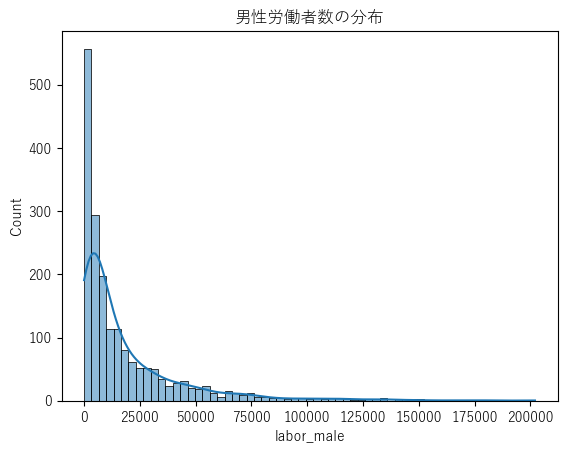

In [149]:
sns.histplot(
	data=labor4,
	x='labor_male',
	kde=True,
	multiple='stack')
plt.title('男性労働者数の分布')
plt.show()

In [122]:
family1 = family[family['district2_id'].isna()]
family2 = family1.drop(columns=['district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
family3 = family2.iloc[:, 0:3]
family4 = family3.replace('-', np.nan, inplace=False)
family5 = family4.astype(float)
family5.head()

,district_id,family_count,family_member_count
0,25201.0,136153.0,340973.0
593,25202.0,45546.0,113679.0
998,25203.0,41788.0,118193.0
1320,25204.0,29784.0,81312.0
1512,25206.0,60224.0,137247.0


c:\Users\YuYaTano\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


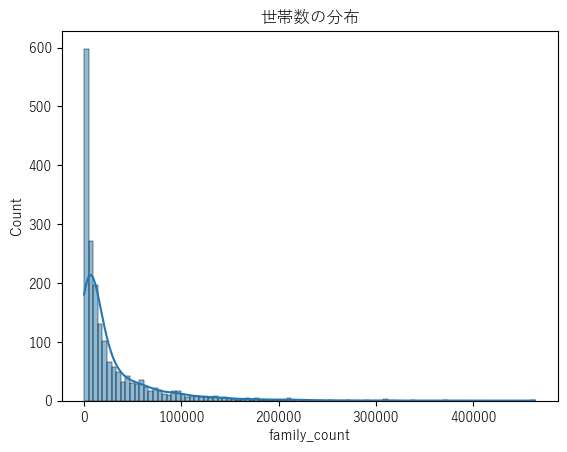

In [148]:
sns.histplot(
	data=family5,
	x='family_count',
	kde=True,
	multiple='stack')
plt.title('世帯数の分布')
plt.show()

In [124]:
# income と family を結合
merged1 = pd.merge(income, family5, how='outer',
                  left_on='area_code', right_on='district_id')
merged1.head()

,area_code,income_mean,district_id,family_count,family_member_count
0,13228.0,480.984419,13228.0,30817.0,80954.0
1,43514.0,439.775281,43514.0,5298.0,15523.0
2,23237.0,487.507769,23237.0,33190.0,86898.0
3,18208.0,505.495103,18208.0,9697.0,28729.0
4,12238.0,385.423846,12238.0,14849.0,38594.0


In [127]:
# merged1 と labor を結合
merged2 = pd.merge(merged1, labor4, how='outer',left_on='area_code', right_on='district_id')
merged2.head()

,area_code,income_mean,district_id_x,family_count,family_member_count,district_id_y,labor_male,no_labor_male,labor_female,no_labor_female
0,13228.0,480.984419,13228.0,30817.0,80954.0,13228.0,21157.0,9370.0,15070.0,16543.0
1,43514.0,439.775281,43514.0,5298.0,15523.0,43514.0,4120.0,1917.0,3939.0,3352.0
2,23237.0,487.507769,23237.0,33190.0,86898.0,23237.0,25057.0,9666.0,18479.0,17560.0
3,18208.0,505.495103,18208.0,9697.0,28729.0,18208.0,8415.0,3396.0,7306.0,6166.0
4,12238.0,385.423846,12238.0,14849.0,38594.0,12238.0,10210.0,6307.0,7823.0,10036.0


In [128]:
#欠損値の補完
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
merged2[["family_count","family_member_count","labor_male","no_labor_male","labor_female","no_labor_female","income_mean"]] = imputer.fit_transform(merged2[["family_count","family_member_count","labor_male","no_labor_male","labor_female","no_labor_female","income_mean"]])

In [158]:
#スケーリング
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scatterd_family_count =  scaler.fit_transform(merged2[["family_count"]])
scatterd_family_member_count =  scaler.fit_transform(merged2[["family_member_count"]])
scatterd_labor_male =  scaler.fit_transform(merged2[["labor_male"]])
scatterd_no_labor_male = scaler.fit_transform(merged2[["no_labor_male"]])
scatterd_labor_female =  scaler.fit_transform(merged2[["labor_female"]])
scatterd_no_labor_female = scaler.fit_transform(merged2[["no_labor_female"]])
scatterd_income =  scaler.fit_transform(merged2[["income_mean"]])

In [130]:
merged3 = np.column_stack((scatterd_family_count, scatterd_labor_male,scatterd_income))
merged3

array([[0.06646665, 0.10466227, 0.48308801],
       [0.01142503, 0.02034948, 0.39423711],
       [0.07158495, 0.12396261, 0.49715299],
       ...,
       [0.02398459, 0.01305   , 0.42433769],
       [0.02398459, 0.00857133, 0.42433769],
       [0.02398459, 0.01116945, 0.42433769]])

上のデータのうち、代表として family_count と labor_male を用いて、機械学習を行う

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [132]:
# 特徴量とターゲットにデータを分ける
X = merged3[:, :2]  # 最初の2列を特徴量に
y = merged3[:, 2]   # 最後の1列をターゲットに

len(X) == len(y)

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

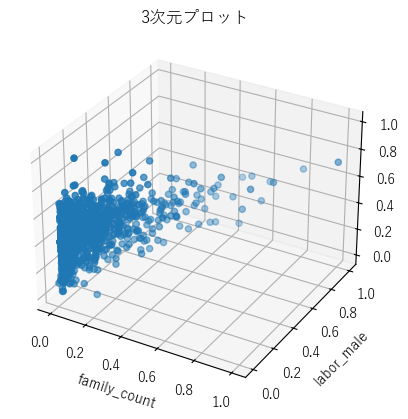

In [151]:
# 3次元プロットを作成
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

family_count = merged3[:,0]
labor_male = merged3[:,1]
income_mean =  merged3[:,2]
# 3D散布図を描画
ax.scatter(family_count,labor_male, income_mean)

# プロットのラベルを設定
ax.set_xlabel("family_count")
ax.set_ylabel("labor_male")
ax.set_zlabel("income_mean")

# プロットを表示
plt.title('3次元プロット')
plt.show()

In [134]:
# モデルのインスタンスを作成
model = LinearRegression()
# モデルの訓練
model.fit(X_train, y_train)

LinearRegression()

In [136]:
from sklearn.metrics import r2_score
import statsmodels.api as sm
# テストデータで予測
y_pred = model.predict(X_test)

# モデルの性能を評価 (平均二乗誤差を使用)
mse = mean_squared_error(y_test, y_pred)

#調整済み決定係数を求める
m = sm.OLS(y_train, sm.add_constant(X_train))
result = m.fit()

print("Mean Squared Error:", mse)
print("R^2 Score:", r2_score(y_test, y_pred))
print("Adjusted:", result.rsquared_adj)

Mean Squared Error: 0.00859473917195916
R^2 Score: 0.029451901759632637
Adjusted: 0.06668823606820695


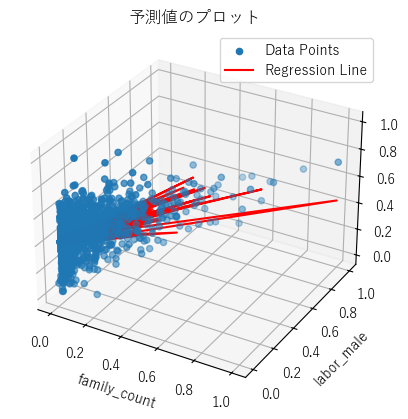

In [152]:
# 予測値のプロット
from mpl_toolkits.mplot3d import Axes3D

# 3次元プロットを作成
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# データをプロット
ax.scatter(family_count, labor_male, income_mean, label='Data Points')

# X_testとy_predが2次元の特徴量とそれに対応する予測値であることを仮定しています
# 例えば、X_testが (labor_male, labor_female) の2次元特徴量で、y_predがincome_meanの予測値の場合
ax.plot(X_test[:, 0], X_test[:, 1], y_pred, color='red', label='Regression Line')

# プロットのラベルを設定
ax.set_xlabel("family_count")
ax.set_ylabel("labor_male")
ax.set_zlabel("income_mean")

# 凡例を追加
ax.legend()

# プロットを表示
plt.title('予測値のプロット')
plt.show()

結果  
平均二乗偏差の値は非常に小さかったものの、決定係数や調整済み決定係数の値はそれぞれ 2.9%, 6.7% と非常に小さく、このモデルの当てはまりが良いとは言えなかった。

考察  
データが上図の左下あたり（いずれも0に近い部分）に固まっており、回帰直線を引く際に、外れ値の影響を大きく受けた可能性がある。
また、世帯数（family_count）と男性労働者数（labor_male）は指数関数に近似されるような分布をしており、正規分布に近似される収入データの予測には向かなかった可能性がある。  
また、相関係数を確認してみると、family_count と labor_male 間の相関係数は0.96と非常に大きく、多重共線性の問題が発生していたと考えられる。

In [157]:
res = merged2.corr()
print(res)

                     area_code  income_mean  district_id_x  family_count  \
area_code             1.000000    -0.321806       1.000000     -0.084657   
income_mean          -0.321806     1.000000      -0.241370      0.202803   
district_id_x         1.000000    -0.241370       1.000000     -0.022215   
family_count         -0.084657     0.202803      -0.022215      1.000000   
family_member_count  -0.084618     0.213258      -0.019304      0.991548   
district_id_y         1.000000    -0.241370       1.000000     -0.031365   
labor_male           -0.103989     0.233413      -0.043167      0.964465   
no_labor_male        -0.069297     0.161785      -0.018395      0.938122   
labor_female         -0.078716     0.209586      -0.025401      0.968489   
no_labor_female      -0.070366     0.176069      -0.019600      0.948946   

                     family_member_count  district_id_y  labor_male  \
area_code                      -0.084618       1.000000   -0.103989   
income_mean          

上の相関係数の結果より、familyデータに含まれる変数とlaborデータに含まれる変数はいずれも相関が非常に大きく、多重共線性の問題は避けられない。  
しかし、折角なので、辛うじて相関係数が0.95を下回っていた、family_countとno_labor_maleを用いて同じように予測値を求めてみた。  
ただし、収入を予測するのに労働に従事していない人の人数という変数を用いる妥当性がどれほどあるのかは不明である。

In [159]:
merged4 = np.column_stack((scatterd_family_count, scatterd_no_labor_male, scatterd_income))
merged4

array([[0.06646665, 0.13242842, 0.48308801],
       [0.01142503, 0.02704843, 0.39423711],
       [0.07158495, 0.13661364, 0.49715299],
       ...,
       [0.02398459, 0.0222128 , 0.42433769],
       [0.02398459, 0.02014846, 0.42433769],
       [0.02398459, 0.01686815, 0.42433769]])

In [160]:
X = merged4[:, :2]  # 最初の2列を特徴量に
y = merged4[:, 2]   # 最後の1列をターゲットに

len(X) == len(y)

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# モデルのインスタンスを作成
model1 = LinearRegression()
# モデルの訓練
model1.fit(X_train, y_train)

LinearRegression()

In [161]:
from sklearn.metrics import r2_score
import statsmodels.api as sm
# テストデータで予測
y_pred1 = model1.predict(X_test)

# モデルの性能を評価 (平均二乗誤差を使用)
mse = mean_squared_error(y_test, y_pred1)

#調整済み決定係数を求める
m = sm.OLS(y_train, sm.add_constant(X_train))
result = m.fit()

print("Mean Squared Error:", mse)
print("R^2 Score:", r2_score(y_test, y_pred1))
print("Adjusted:", result.rsquared_adj)

Mean Squared Error: 0.007058274592984183
R^2 Score: 0.02379069006551604
Adjusted: 0.051005836792270554


上の結果より、決定係数と調整済み決定係数の値は、元々小さかった 2.9%, 6.7%から、更に小さい2.3%, 5.1%となった。やはり、family データと labor データから収入を予測するのは難しそうである。

謝辞  
この課題を行うにあたり、M1の門間晴風さんのご協力を賜った。ここに感謝の意を表したい。